In [3]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

### Dataset

In [4]:
class L96Dataset(Dataset):
    def __init__(self, csv_file, data_dir, ids, scaler=None):
        self.df = pd.read_csv(csv_file)
        self.df = self.df[self.df['id'].isin(ids)]
        self.data_dir = data_dir
        self.scaler = scaler

        self.inputs, self.targets = [], []
        for _, row in self.df.iterrows():
            id_str = row['id']
            F = row['F']
            target = row['E_time_mean']
            # load x0 vector
            x0_path = os.path.join(data_dir, f"x0_{int(id_str):07d}.npy")
            x0 = np.load(x0_path)
            x = np.concatenate([[F], x0])  # shape (41,)
            self.inputs.append(x)
            self.targets.append(target)

        self.inputs = np.array(self.inputs, dtype=np.float32)
        self.targets = np.array(self.targets, dtype=np.float32).reshape(-1, 1)

        # Scale inputs if scaler provided
        if self.scaler:
            self.inputs = self.scaler.transform(self.inputs)

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return torch.tensor(self.inputs[idx]), torch.tensor(self.targets[idx])

### Flexible Neural Network

In [5]:
class FlexibleNN(nn.Module):
    def __init__(self, input_dim, hidden_layers=[64, 32]):
        super(FlexibleNN, self).__init__()
        layers = []
        prev_dim = input_dim
        for h in hidden_layers:
            layers.append(nn.Linear(prev_dim, h))
            layers.append(nn.ReLU())
            prev_dim = h
        layers.append(nn.Linear(prev_dim, 1))  # scalar output
        self.net = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.net(x)

### Training Pipeline

In [6]:
def train_model(model, train_loader, val_loader, epochs=50, lr=1e-3, device="cpu"):
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    
    history = {"train_loss": [], "val_loss": []}
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            y_pred = model(x)
            loss = criterion(y_pred, y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * x.size(0)
        
        train_loss /= len(train_loader.dataset)
        
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                y_pred = model(x)
                loss = criterion(y_pred, y)
                val_loss += loss.item() * x.size(0)
        
        val_loss /= len(val_loader.dataset)
        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}")
    
    return model, history

In [17]:
def run_experiments(input_dim, train_loader, val_loader, architectures, epochs=50, lr=1e-3, device="cpu"):
    results = {}
    for arch in architectures:
        print(f"Training architecture: {arch}")
        model = FlexibleNN(input_dim, hidden_layers=arch)
        trained_model, history = train_model(model, train_loader, val_loader, epochs=epochs, lr=lr, device=device)
        results[str(arch)] = history["val_loss"][-1]
    return results

### Visualizations

In [8]:
def plot_results(results):
    plt.plot(list(results.keys()), list(results.values()), marker="o")
    plt.xlabel("Architecture")
    plt.ylabel("Final Validation Loss")
    plt.title("Performance vs Network Size - 50 epochs")
    plt.xticks(rotation=45)
    plt.show()

In [9]:
def plot_predictions_vs_true(y_true, y_pred):
    """Scatter plot: predicted vs. true values."""
    plt.figure(figsize=(6,6))
    plt.scatter(y_true, y_pred, alpha=0.7)
    max_val = max(y_true.max(), y_pred.max())
    min_val = min(y_true.min(), y_pred.min())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', label="Ideal Fit")
    plt.xlabel("True E_time_mean")
    plt.ylabel("Predicted E_time_mean")
    plt.title("Predicted vs. True")
    plt.legend()
    plt.grid(True)
    plt.savefig("preds_vs_true.png")
    plt.show()

In [10]:
def plot_val_vs_rmse(results, rmses):
    archs = list(results.keys())
    val_losses = [results[a] for a in archs]
    test_rmses = [rmses[a] for a in archs]

    fig, ax1 = plt.subplots(figsize=(10, 6))

    ax1.set_xlabel("Architecture")
    ax1.set_ylabel("Validation Loss", color="tab:blue")
    ax1.plot(archs, val_losses, marker="o", color="tab:blue", label="Validation Loss")
    ax1.tick_params(axis="y", labelcolor="tab:blue")
    ax1.set_yscale("log")

    ax2 = ax1.twinx()
    ax2.set_ylabel("Test RMSE", color="tab:red")
    ax2.plot(archs, test_rmses, marker="s", color="tab:red", label="Test RMSE")
    ax2.tick_params(axis="y", labelcolor="tab:red")

    plt.title("Validation Loss vs Test RMSE by Architecture")
    fig.tight_layout()
    plt.show()

### Evaluation

In [11]:
def evaluate_model(model, test_loader, device="cpu"):
    model.eval()
    preds, trues = [], []
    with torch.no_grad():
        for X, y in test_loader:
            X, y = X.to(device), y.to(device)
            preds.append(model(X).cpu().numpy())
            trues.append(y.cpu().numpy())
    preds = np.vstack(preds)
    trues = np.vstack(trues)
    return preds, trues

### Get RMSE

In [12]:
def evaluate_rmse(model, test_loader, device="cpu"):
    model.eval()
    preds, trues = [], []
    with torch.no_grad():
        for X, y in test_loader:
            X, y = X.to(device), y.to(device)
            preds.append(model(X).cpu().numpy())
            trues.append(y.cpu().numpy())
    preds = np.vstack(preds)
    trues = np.vstack(trues)
    rmse = np.sqrt(np.mean((preds - trues) ** 2))
    return rmse

def run_experiments_full(input_dim, train_loader, val_loader, test_loader, architectures, epochs=50, lr=1e-3, device="cpu"):
    results = {}
    histories = {}
    rmses = {}

    for arch in architectures:
        print(f"Training architecture: {arch}")
        model = FlexibleNN(input_dim, hidden_layers=arch)
        trained_model, history = train_model(model, train_loader, val_loader, epochs=epochs, lr=lr, device=device)
        
        # Store final validation loss
        results[str(arch)] = history["val_loss"][-1]
        histories[str(arch)] = history
        
        # Compute RMSE on test set
        rmse = evaluate_rmse(trained_model, test_loader, device=device)
        rmses[str(arch)] = rmse
        print(f"Architecture {arch} → Test RMSE: {rmse:.6f}")

    return results, histories, rmses

In [18]:
data_dir = "../data/l96_N40_T20_S600_1000"
csv_file = os.path.join(data_dir, "targets_time_mean_energy.csv")

# Read all IDs
df = pd.read_csv(csv_file)
ids = df['id'].tolist()

# Train/val/test split
train_ids, test_ids = train_test_split(ids, test_size=0.15, random_state=42)
train_ids, val_ids = train_test_split(train_ids, test_size=0.176, random_state=42)  # 0.176*0.85 ≈ 0.15

# Fit scaler on training inputs
all_inputs = []
for id_str in train_ids:
  row = df[df['id'] == id_str].iloc[0]
  F = row['F']
  x0 = np.load(os.path.join(data_dir, f"x0_{int(id_str):07d}.npy"))
  all_inputs.append(np.concatenate([[F], x0]))
scaler = StandardScaler().fit(np.array(all_inputs, dtype=np.float32))

# Create datasets
train_ds = L96Dataset(csv_file, data_dir, train_ids, scaler)
val_ds = L96Dataset(csv_file, data_dir, val_ids, scaler)
test_ds = L96Dataset(csv_file, data_dir, test_ids, scaler)

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=16, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=16, shuffle=False)

architectures = [
  [128, 64],
  [64, 32],
  [32, 16],
  [16],
  [8],
]
'''
# ** Get RMSE **
results, histories, rmses = run_experiments_full(
input_dim=41,
train_loader=train_loader,
val_loader=val_loader,
test_loader=test_loader,
architectures=architectures,
epochs=50
)

plot_val_vs_rmse(results, rmses)
'''

results = run_experiments(input_dim=41, 
                          train_loader=train_loader, 
                          val_loader=val_loader, 
                          architectures=architectures, 
                          epochs=50)

Training architecture: [128, 64]
Epoch 1/50, Train Loss: 405621.502857, Val Loss: 348388.932083
Epoch 2/50, Train Loss: 337915.146875, Val Loss: 228981.624583
Epoch 3/50, Train Loss: 157106.338036, Val Loss: 86044.917188
Epoch 4/50, Train Loss: 75483.116964, Val Loss: 74389.102865
Epoch 5/50, Train Loss: 72470.051295, Val Loss: 73622.408333
Epoch 6/50, Train Loss: 71329.223415, Val Loss: 72117.963281
Epoch 7/50, Train Loss: 69976.675848, Val Loss: 70991.335990
Epoch 8/50, Train Loss: 68239.966518, Val Loss: 69542.117552
Epoch 9/50, Train Loss: 66579.282500, Val Loss: 68051.115365
Epoch 10/50, Train Loss: 64573.589955, Val Loss: 66121.454792
Epoch 11/50, Train Loss: 62165.683415, Val Loss: 63624.342969
Epoch 12/50, Train Loss: 59240.090558, Val Loss: 60505.228906
Epoch 13/50, Train Loss: 55780.074129, Val Loss: 57199.093281
Epoch 14/50, Train Loss: 51347.025156, Val Loss: 52380.644583
Epoch 15/50, Train Loss: 45474.318772, Val Loss: 45937.184375
Epoch 16/50, Train Loss: 38828.412600, Va

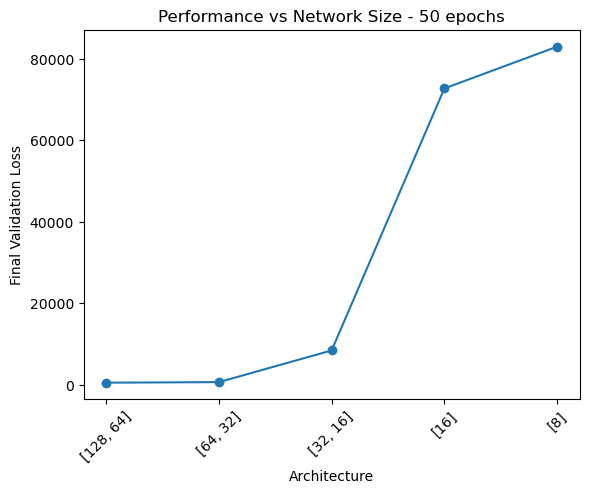

In [19]:
plot_results(results)

In [20]:
# Train final model on chosen architecture
best_arch = min(results, key=results.get)  # architecture with lowest val loss
print(f"Best architecture: {best_arch}")

Best architecture: [128, 64]


In [21]:
final_model = FlexibleNN(input_dim=41, hidden_layers=eval(best_arch))
final_model, _ = train_model(final_model, train_loader, val_loader, epochs=50)

# Evaluate on test set
preds, trues = evaluate_model(final_model, test_loader)

Epoch 1/50, Train Loss: 407126.875357, Val Loss: 352079.590833
Epoch 2/50, Train Loss: 348247.335536, Val Loss: 245554.289583
Epoch 3/50, Train Loss: 177030.035670, Val Loss: 97232.049167
Epoch 4/50, Train Loss: 77612.489554, Val Loss: 74458.821927
Epoch 5/50, Train Loss: 72518.860558, Val Loss: 73075.452031
Epoch 6/50, Train Loss: 71173.030536, Val Loss: 72104.964635
Epoch 7/50, Train Loss: 69730.940000, Val Loss: 70574.470990
Epoch 8/50, Train Loss: 68235.125848, Val Loss: 69049.045625
Epoch 9/50, Train Loss: 66222.354643, Val Loss: 67408.100208
Epoch 10/50, Train Loss: 64193.202969, Val Loss: 65210.368594
Epoch 11/50, Train Loss: 61355.240379, Val Loss: 62256.445625
Epoch 12/50, Train Loss: 57931.444263, Val Loss: 58109.571875
Epoch 13/50, Train Loss: 53570.395156, Val Loss: 53897.473177
Epoch 14/50, Train Loss: 48070.685067, Val Loss: 48722.532656
Epoch 15/50, Train Loss: 41531.073482, Val Loss: 41225.357630
Epoch 16/50, Train Loss: 34467.602612, Val Loss: 34700.845182
Epoch 17/50,

In [22]:
# compute RMSE
rmse = np.sqrt(np.mean((preds - trues) ** 2))
print(f"Test RMSE: {rmse:.6f}")

Test RMSE: 21.753704


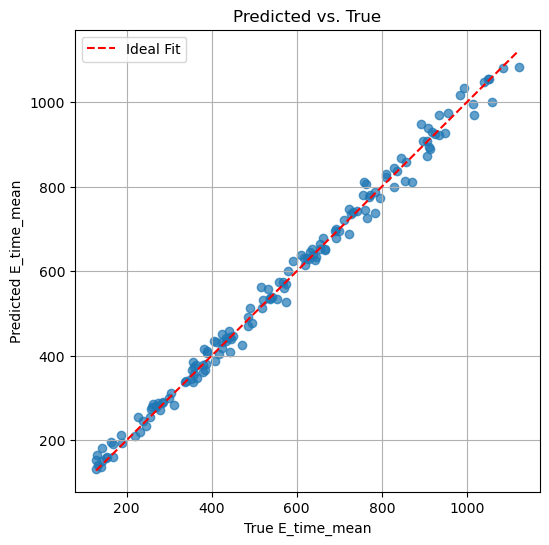

In [23]:
plot_predictions_vs_true(trues, preds)